In [159]:
# imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

In [104]:
# Generate square
def add_square(img, center, width):
  start_point = (center[0]-width, center[1]-width)
  end_point   = (center[0]+width, center[1]+width)
  cv2.rectangle(img, start_point, end_point, (255, 255, 255),cv2.FILLED)

In [96]:
# generate sample
def create_data_sample(num_shapes, height, width):
  img = np.zeros((height, width, 3))
  label = np.zeros((height, width, 1))
  for i in range(num_shapes):
    x = int(np.random.rand()*width)
    y = int(np.random.rand()*height)
    if np.random.rand() > 0.5:
      cv2.circle(img, (x,y), int(np.ceil(width*0.05)), (255, 255, 255), cv2.FILLED)
      cv2.circle(label, (x,y), int(np.ceil(width*0.02)), (1, 1, 1), cv2.FILLED)
    else:
      add_square(img, (x,y), int(np.ceil(width*0.05*0.7)))
  return img, label


In [74]:
def test_batch(num_shapes, height, width):
  img, label = create_data_sample(num_shapes, height, width)
  return np.expand_dims(img,0), np.expand_dims(label,0)

In [75]:
def grayscale_image(img):
  return np.expand_dims((img[:,:,0] + img[:,:,1] + img[:,:,2])/3,2)

In [6]:
# (128,128,1) --> (128,128,3)
def to_three_channels(img):
  return np.squeeze(np.stack((img,img,img), 2))

In [8]:
def show_sample(img, label):
  figure, axis = plt.subplots(1,2)
  axis[0].imshow(img)
  axis[1].imshow(to_three_channels(label))

In [9]:
def show_batch(img, label):
  show_sample(img[0,:,:,:],label[0,:,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


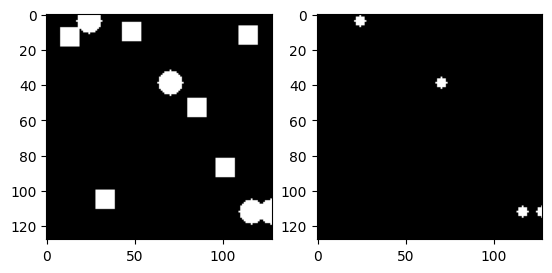

In [114]:
img_shape = (128, 128, 1)
img, label = create_data_sample(10, img_shape[0], img_shape[1]) # data smaple with 10 shapes, height, width
show_sample(img, label)

In [126]:
# Training model type setup
#l2 = keras.regularizers.l2(1e-5)
l2 = None
inputs = keras.Input(shape = img_shape)
conv1 = keras.layers.Conv2D(16, 5, padding='same', activation='relu', kernel_initializer='glorot_normal', kernel_regularizer = l2)(inputs)
conv1 = keras.layers.BatchNormalization(momentum = 0.99)(conv1)
conv2 = keras.layers.Conv2D(32, 5, padding='same', activation='relu', kernel_initializer='glorot_normal', kernel_regularizer = l2)(conv1)
conv2 = keras.layers.BatchNormalization(momentum = 0.99)(conv2)
outputs = keras.layers.Conv2D(1, 5, padding='same', activation='relu', kernel_initializer='glorot_normal', kernel_regularizer = l2)(conv2)
model = keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      1216      
                                                                 
 batch_normalization_2 (Bat  (None, 128, 128, 16)      64        
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      12832     
                                                                 
 batch_normalization_3 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 1)       801 

In [128]:
# Recognition loss
def loss_function(y_true, y_pred):
  squared_diff = tf.square(y_true - y_pred)
  return tf.reduce_mean(squared_diff)


In [155]:
# Generate data sample for teaching model
x_list = []
y_list = []
for i in range(1000):
  x,y  = create_data_sample(10, img_shape[0], img_shape[1])
  x_list.append(x)
  y_list.append(y)
x_list = np.array(x_list)
y_list = np.array(y_list)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


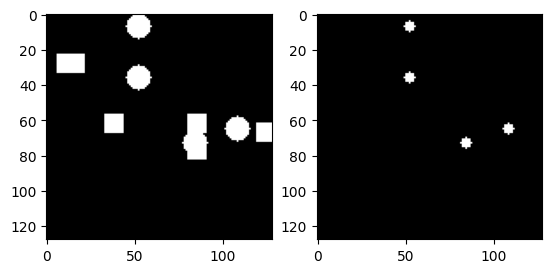

In [156]:
i = 2
show_sample(x_list[i], y_list[i])

In [131]:
x_list.shape

(1000, 128, 128, 3)

In [160]:
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt,loss=loss_function)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [152]:
# train model
model.fit(x_list, y_list, batch_size=None, epochs=2)

Epoch 1/2
 2/32 [>.............................] - ETA: 20s - loss: 0.0164

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


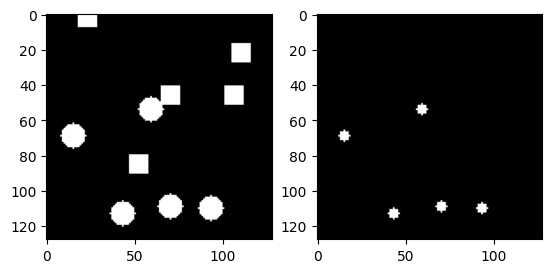

In [144]:
img, label = test_batch(10, img_shape[0], img_shape[1])
show_batch(img,label)

1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.1304467


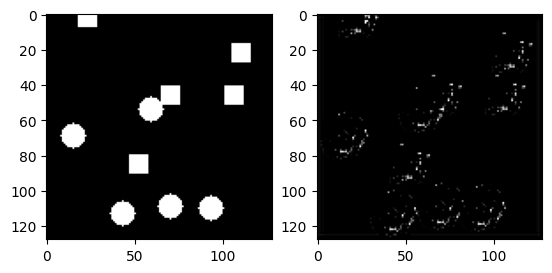

In [145]:
y_pred = model.predict(img)
print(y_pred.max())
show_batch(img, y_pred)

In [63]:
loss_function(y_pred, label)

<tf.Tensor: shape=(), dtype=float64, numpy=0.010542003306335389>